In [3]:
import os
import pandas as pd
import pathlib
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from ast import literal_eval
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from presolve_datasets import *
from networks import *

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [ ]:
# writer = SummaryWriter(f'runs/cartpole-{time.strftime("%Y%m%d-%H%M%S")}')
%reload_ext tensorboard
%tensorboard --logdir=runs

## Define Dataset and DataLoader

In [5]:
path = 'data/presolves/cartpole_DIRCOL_5000.csv'
train_data = NLPDataset(path, train=True)
test_data = NLPDataset(path, train=False)

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

params, Z = next(iter(train_dataloader))

In [13]:
cartpole_data = NLPDataset(path, train=True)
cartpole_data.n_params
cartpole_data.n_traj
# cartpole_data.df['X'].iloc[0].shape[0]



204

In [13]:
model = CartpoleNN(train_data.n_params, train_data.n_traj).to(device)
print(f"Model structure: {model}\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")


Model structure: CartpoleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=204, bias=True)
  )
)




In [11]:
path = 'data/presolves/cartpole_DIRCOL_5000.csv'
t_vec = []
nx, nu, N = 4, 1, 41
t_vec = np.linspace(0, 2, N)

cartpole_warmstart = POCPSolver(path, t_vec, nx, nu, N)

## Training Loop

In [7]:
# cartpole_warmstart.train()

100%|██████████| 100/100 [03:56<00:00,  2.37s/it]


## Visualize the MLP Generated Warm-Start

In [9]:
# model = torch.load('models/cartpole_model1.pth')
model.eval()
# rand_param = torch.rand()

param_lower = [0.0, 0.0]
param_upper = [0.2, np.pi/2]

rand_param = torch.rand(len(param_lower)) * (torch.tensor(param_upper) - torch.tensor(param_lower)) + torch.tensor(param_lower)
rand_param = rand_param.double()

Z = None
with torch.no_grad():
    # rand_param = rand_param.to(device)
    test_param  = torch.from_numpy(test_data.df.iloc[1].params)
    test_param = test_param.to(device)
    start = time.process_time()
    Z = model(test_param)
    end = time.process_time()
Z = Z.detach().cpu().numpy()

print(end-start)


NameError: name 'model' is not defined

In [18]:
from utils.trajectory_utils import create_idx
nx, nu, N = 4, 1, 41
# nx, nu, N, nz, nc, x, u, c= create_idx(nx, nu, N)
idx = create_idx(nx, nu, N)

t_vec = np.linspace(0, 2, N)

print(test_data.df.iloc[2].solve_time_sec)

print(idx)
plt.plot(t_vec, Z[idx.X][:,:2], linewidth=3.0)
plt.plot(t_vec, test_data.df.iloc[1].X[:,0], '--', linewidth=3.0, color='tab:blue')
plt.plot(t_vec, test_data.df.iloc[1].X[:,1], '--', linewidth=3.0, color='tab:orange')

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

plt.grid(True)
mpl.rc('font', **font)

plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend(['x', r'$\theta$', 'x (NLP)', r'$\theta$ (NLP)'])

ModuleNotFoundError: No module named 'utils'

In [15]:
path = pathlib.Path(r'C:\Users\AiPEX-WS4\Documents\AiPEX-Projects\warmstarting_NLPs\models\cartpole_model1.pth')
cartpole_warmstart.load_model(path)

Model loaded successfully!


c:\Users\AiPEX-WS4\Documents\AiPEX-Projects\warmstarting_NLPs\networks.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  assert idx < len(self.test_data)


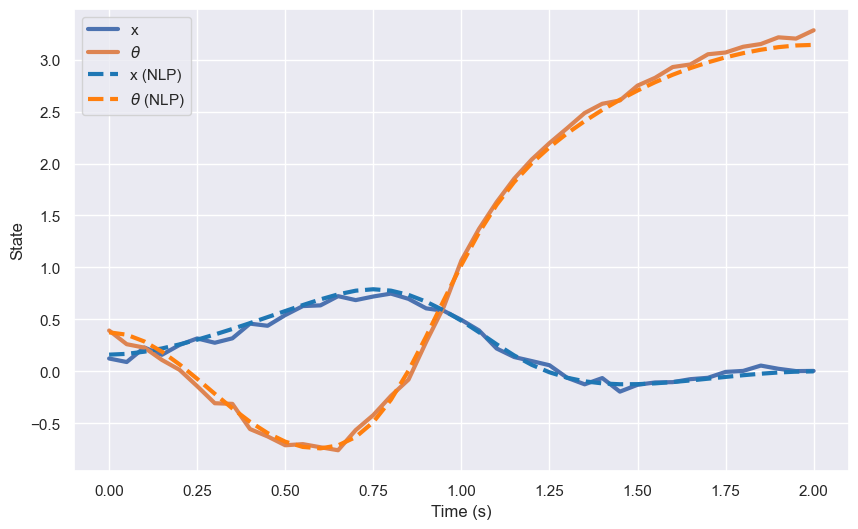

In [26]:
cartpole_warmstart.compare_trajectories(15)


## Go through the test dataset and store the MLP generated warmstart trajectories

In [36]:
warmstart_df = test_data.df.copy()
warmstart_df.shape

warmstart_df['X_warmstart'] = None
warmstart_df['U_warmstart'] = None
warmstart_df['Z_warmstart'] = None

warmstart_df['inference_time_sec'] = None



# warmstart_df.head()
for index, row in warmstart_df.iterrows():
    test_param  = torch.from_numpy(row.params)
    test_param = test_param.to(device)
    
    with torch.no_grad():
        start = time.process_time()
        Z = model(test_param)
        end = time.process_time()
    Z = Z.detach().cpu().numpy()

    warmstart_df.at[index, 'inference_time_sec'] = end - start
    # print(type(Z[idx.X]))
    warmstart_df.at[index, 'X_warmstart'] = Z[idx.X]
    warmstart_df.at[index, 'U_warmstart'] = Z[idx.U]
    print(Z.shape)
    warmstart_df.at[index, 'Z_warmstart'] = Z

    # warmstart_df.['inference_time_sec'] = end-start
    # row['X_warmstart'] = Z[idx.X]
    # row['U_warmstart'] = Z[idx.U]
    # print(row)


warmstart_df.head()



(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)

,params,X,U,obj,solve_time_sec,term_status,X_warmstart,U_warmstart,Z_warmstart,inference_time_sec
1826,"[0.19927050795585702, 0.30560027123739736]","[[0.19927050795585702, 0.30560027123739736, 0....","[[4.624766020526614], [3.7150142900837873], [3...",403.873641,1.161033,LOCALLY_SOLVED,"[[0.17014038177457444, 0.3197183089026185, -0....","[[6.317622762726378], [4.709280773573871], [3....","[0.17014038177457444, 0.3197183089026185, -0.0...",0.0
4233,"[0.03700828967086683, 1.3984284368214417]","[[0.03700828967086683, 1.3984284368214417, 0.0...","[[8.563937999558723], [7.437770573144867], [5....",509.821580,0.878283,LOCALLY_SOLVED,"[[0.060329461838231284, 1.3530448090633784, 0....","[[8.103925259455073], [6.250883104680437], [3....","[0.060329461838231284, 1.3530448090633784, 0.0...",0.0
3114,"[0.09979782232967992, 1.2316853395256937]","[[0.09979782232967992, 1.2316853395256937, -7....","[[8.547707114699424], [6.669486249781027], [4....",487.379558,0.776175,LOCALLY_SOLVED,"[[0.06702745576638663, 1.2304274142127474, 0.0...","[[7.765116278919022], [6.000296368447923], [3....","[0.06702745576638663, 1.2304274142127474, 0.04...",0.0
2366,"[0.1667736845602924, 0.16362577304598577]","[[0.1667736845602924, 0.16362577304598577, 0.0...","[[7.222161307942146], [6.082617023519561], [5....",398.681969,1.518023,LOCALLY_SOLVED,"[[0.1716985470175058, 0.1649060962141866, -0.0...","[[6.04255706282113], [4.4737675359014], [3.523...","[0.1716985470175058, 0.1649060962141866, -0.07...",0.0
3094,"[0.08334178987275496, 1.0506542569203796]","[[0.08334178987275496, 1.0506542569203796, 0.0...","[[7.722883022387507], [5.334875617800323], [2....",464.931622,0.636347,LOCALLY_SOLVED,"[[0.07857697360853633, 1.0720784614496655, 0.0...","[[7.438125878040006], [5.692078030610056], [3....","[0.07857697360853633, 1.0720784614496655, 0.01...",0.0


In [34]:
warmstart_df.to_csv('data/warmstart_cartpole.csv')


In [28]:
cartpole_warmstart.store_warmstart_trajectories('data/warmstart_trajectories/cartpole_test.csv')

## Visualize histograms for solve time

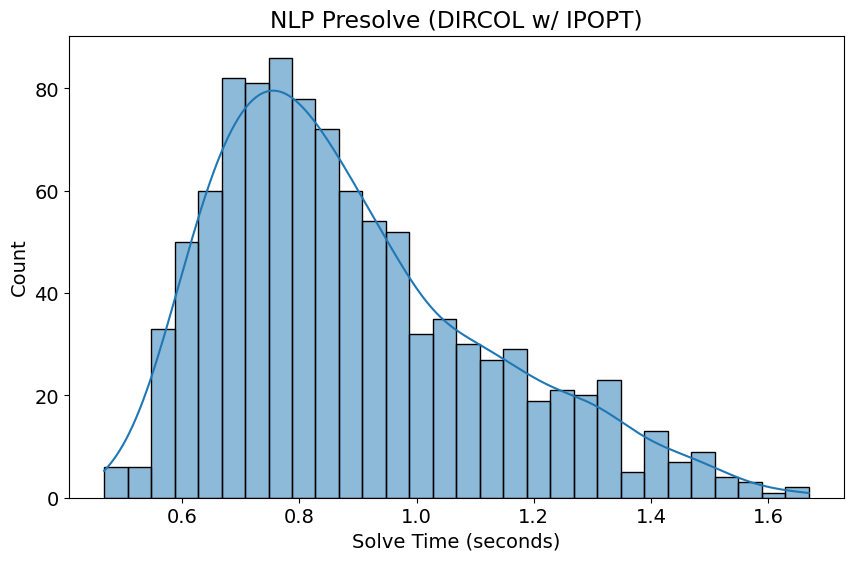

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(warmstart_df['solve_time_sec'], bins=30, kde=True)
plt.xlabel('Solve Time (seconds)')
plt.ylabel('Count')
plt.title('NLP Presolve (DIRCOL w/ IPOPT)')
plt.show()

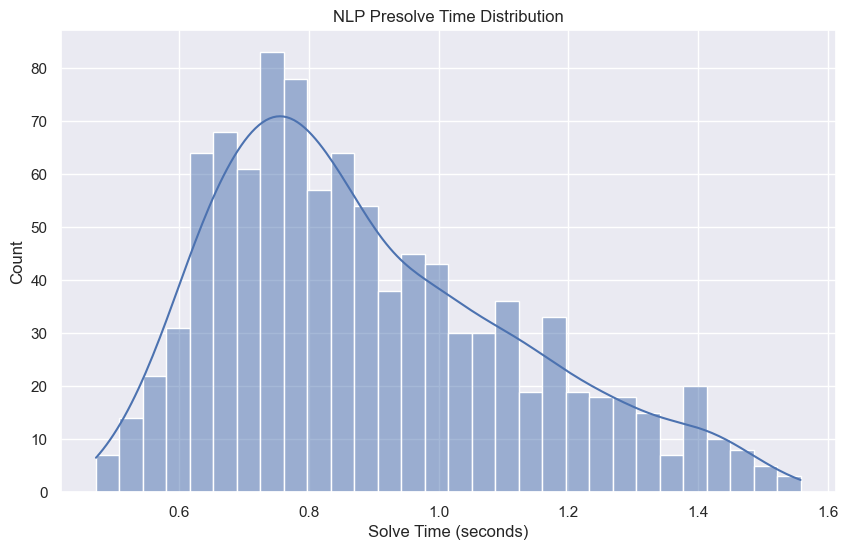

In [34]:
cartpole_warmstart.compare_solve_time()

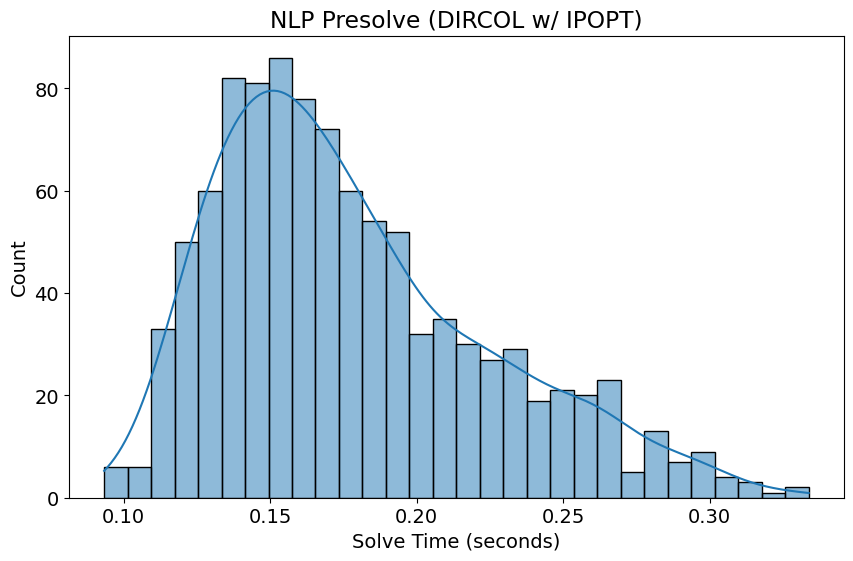

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(warmstart_df['solve_time_sec']/5, bins=30, kde=True)
plt.xlabel('Solve Time (seconds)')
plt.ylabel('Count')
plt.title('NLP Presolve (DIRCOL w/ IPOPT)')
plt.show()